In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")

# Data Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)

# Visualizing Treesn imports
from scipy.stats import norm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.collections import PatchCollection

## Load in pickle files

`data` folder located in parent directory for easy sharing between files.

In [2]:
crsp_prices = pd.read_pickle("../data/crsp_prices.pkl")
dataset = pd.read_pickle("../data/dataset.pkl")

## Add Necessary Features

`dataset` lacks an `spy_ret` feature, so we construct one using `crsp_prices`. Because `crsp_prices` has a date index that is a superset of `dataset`'s date index, this workflow prevents the occurence of NaN values.

#### Homework Question 1 = `dataset["outperform_spy(1)"]`

#### Homework Question 2 = `dataset["tranche_spy(2)"]`

In [3]:
# Choose ticker=="A" as the template because it has a full time series of data.
first_spy_ret = crsp_prices["spy_cum_ret"].values[0]
spy_rets = crsp_prices.loc[crsp_prices.index.get_level_values(0)=="A", "spy_cum_ret"].diff().fillna(first_spy_ret)
spy_rets.index = spy_rets.index.get_level_values(1) # Reindex for slicing
dataset["spy_ret"] = spy_rets.loc[dataset.index.get_level_values(0)].values

# Compute features
dataset["prem_spy"] = dataset["return"] - dataset["spy_ret"]
dataset["outperform_spy(1)"] = np.where((dataset["prem_spy"] > 0), 1, -1)

tranche_spy = np.zeros(len(dataset))
tranches = [0.01, 0.05] # Add tranches as you please
for t in tranches:
    tranche_spy += np.where(dataset["prem_spy"]>t, 1, 0)
    tranche_spy += np.where(dataset["prem_spy"]<-t, -1, 0)
dataset["tranche_spy(2)"] = tranche_spy.astype(int)

In [4]:
hw_cols = ["return", "cum_ret", "spy_ret", "spy_cum_ret",
           "prem_spy", "outperform_spy(1)", "tranche_spy(2)"]
pd.concat([dataset.iloc[:, :4], dataset.loc[:,hw_cols]], axis=1)
#          ^ original dataset                 ^ new features

actq      apq        atq       ceqq  return  cum_ret  \
date       ticker                                                             
2000-02-01 LLB       3.5400   0.1430     7.6680     6.7320 -0.0556   1.3635   
2000-02-03 MYR     107.6610  24.3870   220.4630   136.5550  0.0064   0.0107   
2000-02-08 LZB     447.7190  57.8930   740.9050   460.6120  0.0573  -0.1042   
           SJM     234.4150  33.8210   488.1360   322.4320  0.0034  -0.1122   
2000-02-09 CSCO   7722.0000 482.0000 21391.0000 16523.0000  0.0238   0.2006   
...                     ...      ...        ...        ...     ...      ...   
2018-12-31 ELLO     77.7860   1.9070   255.1230    90.9490 -0.0364   0.8452   
           MFCB     84.0400  20.5860   252.1260   186.1530  0.1664  -0.3146   
           MFCB     79.6280  16.4370   242.7570   193.9290  0.1664  -0.3146   
           PETZ     13.6700   6.3950    18.8330     6.4590 -0.0154  -1.1951   
           SGOC     15.4290   0.0880   156.1870    98.3440 -0.0556   3.6445   

                   spy_ret  spy_cum_ret  prem_spy  outperform_spy(1)  \
date       ticker                                                      
2000-02-01 LLB      0.0094      -0.0368   -0.0650                 -1   
2000-02-03 MYR      0.0151      -0.0209   -0.0087                 -1   
2000-02-08 LZB      0.0136      -0.0130    0.0437                  1   
           SJM      0.0136      -0.0130   -0.0102                 -1   
2000-02-09 CSCO    -0.0210      -0.0340    0.0449                  1   
...                    ...          ...       ...                ...   
2018-12-31 ELLO     0.0088       1.2380   -0.0451                 -1   
           MFCB     0.0088       1.2380    0.1577                  1   
           MFCB     0.0088       1.2380    0.1577                  1   
           PETZ     0.0088       1.2380   -0.0241                 -1   
           SGOC     0.0088       1.2380   -0.0643                 -1   

                   tranche_spy(2)  
date       ticker                  
2000-02-01 LLB                 -2  
2000-02-03 MYR                  0  
2000-02-08 LZB                  1  
           SJM                 -1  
2000-02-09 CSCO                 1  
...                           ...  
2018-12-31 ELLO                -1  
           MFCB                 2  
           MFCB                 2  
           PETZ                -1  
           SGOC                -2  

[294412 rows x 11 columns]

## Visualize the data

To ensure we labeled the tranches correctly.

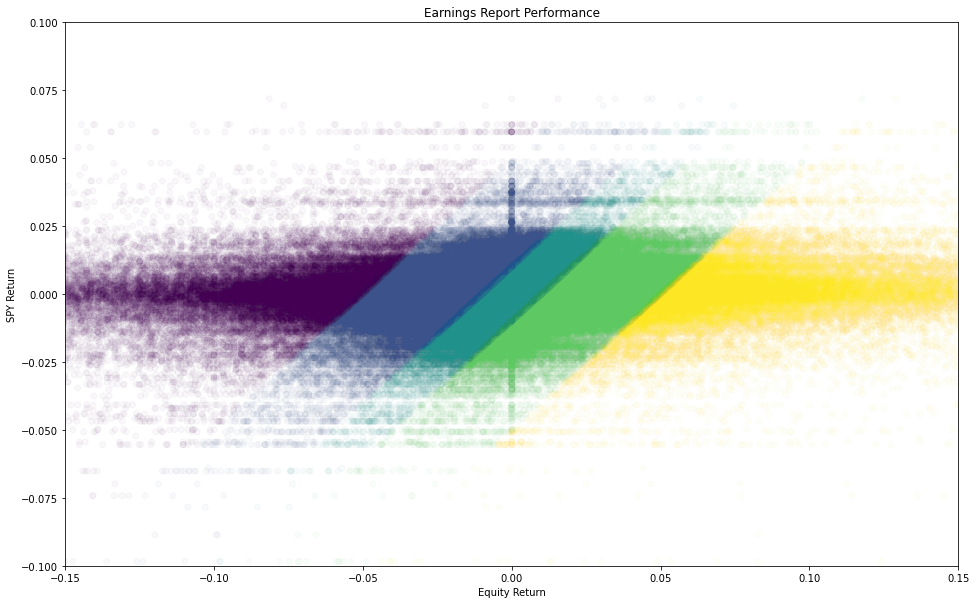

In [5]:
plt.scatter(dataset["return"], dataset["spy_ret"], c=dataset["tranche_spy(2)"], alpha=0.03)
plt.title("Earnings Report Performance")
plt.xlabel("Equity Return")
plt.xlim([-0.15,0.15])
plt.ylabel("SPY Return")
plt.ylim([-0.1,0.1])
plt.show()

In [6]:
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
target = norm.pdf((x - 0.75) / 1) + norm.pdf((y - 0.75) / 0.01) \
        + norm.pdf((x - 0.25) / 0.1) + norm.pdf((y - 0.25) / 1) \
        + np.array(np.round(np.random.normal(-0.1,0.1, n), 2))

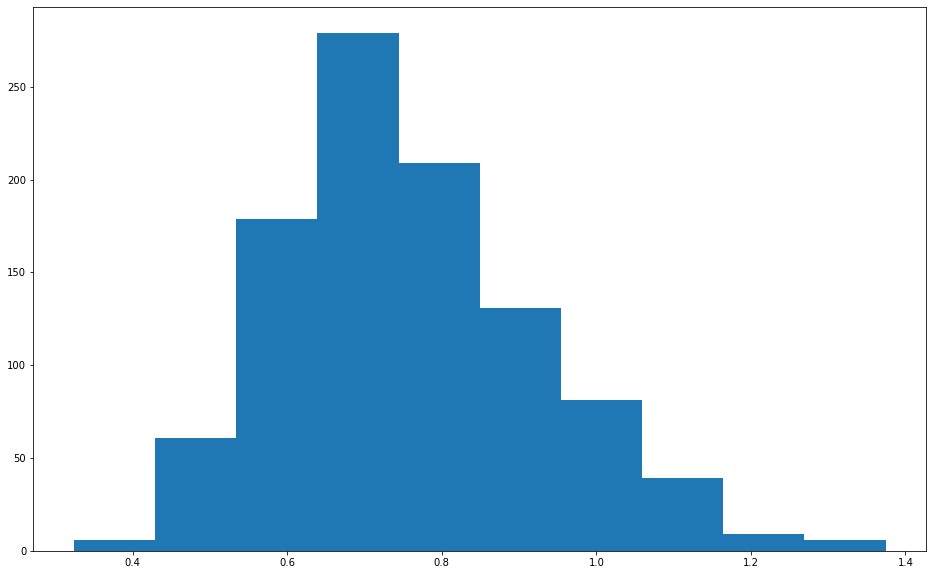

In [7]:
a = plt.hist(target,bins=10)[1]

In [8]:
a

array([0.32383273, 0.42887033, 0.53390793, 0.63894553, 0.74398313,
       0.84902073, 0.95405834, 1.05909594, 1.16413354, 1.26917114,
       1.37420874])

In [9]:
def f(x):
    for i in range(len(a)):
        if x <= a[i]:
            return i
        else:
            continue   

In [10]:
labels = np.array([f(x) for x in target])

In [11]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

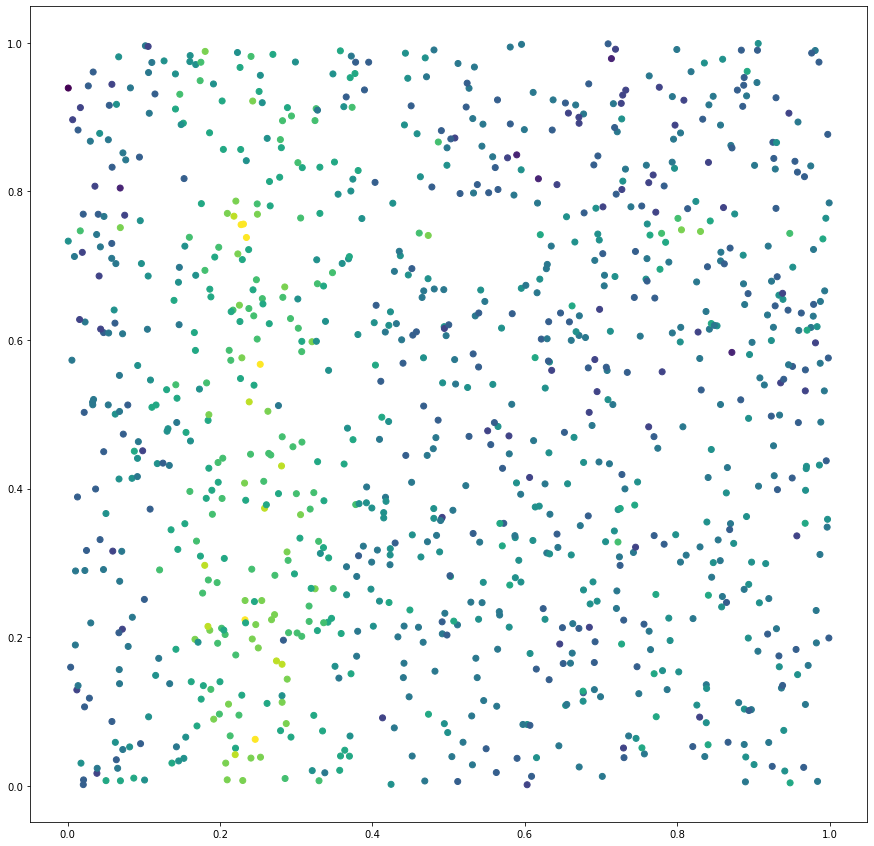

In [12]:
# Plot all points
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(x, y, c = labels);

In [13]:
data1 = pd.DataFrame({'x' : x, 'y' : y})
tree_class = DecisionTreeClassifier(max_depth=10,min_samples_leaf = 10,max_features=0.5)
tree_class.fit(data1,labels)

tree_reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf = 10,max_features=0.5)
tree_reg.fit(data1,labels)

DecisionTreeRegressor(max_depth=10, max_features=0.5, min_samples_leaf=10)

In [14]:
data1

,x,y
0,0.2469,0.2170
1,0.4917,0.2046
2,0.0222,0.1062
3,0.9790,0.6480
4,0.0209,0.0079
...,...,...
995,0.9590,0.4889
996,0.1415,0.9110
997,0.3881,0.3226
998,0.6154,0.0379


In [15]:
def boxes(tree,data,labels):
    
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    def split(i):
    
        left = children_left[i]
        right = children_right[i]
    
        return (left,right)  


    def parent(i):
        splits = enumerate([split(i) for i in range(n_nodes)])
        for a,b in splits:
            if (b[0] == i) or (b[1] == i):
                return a
            else: continue
    
    
    
    def box(i):
    
        (a,b),(c,d) = (0,0),(0,0)
    
        if i == 0:
            (a,b) = (0,0)
            (c,d) = (1,1)
        else:
            j = parent(i)
            t = threshold[j]
            (a,b),(c,d) = box(j)
            
            if feature[j] == 0:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (t,d)
                else:
                    (a,b) = (t,b)
                    (c,d) = (c,d)
                    
            if feature[j] == 1:
                if i == split(j)[0]:
                    (a,b) = (a,b)
                    (c,d) = (c,t)
                else:
                    (a,b) = (a,t)
                    (c,d) = (c,d)
                
        return (a,b),(c,d)

    boxes = []
    for i in range(n_nodes):
        boxes.append(box(i))
        
    fig, ax = plt.subplots(figsize = (10,10))
    ax.scatter(x, y, c = target);



    for i in range(1,n_nodes):
    
        j = parent(i)
        t = threshold[j]
        ((a,b),(c,d)) = boxes[j]
        if feature[j] == 0:
            ax.vlines(t, b, d, colors='k')
        else:
            ax.hlines(t,a,c,colors='k') 
            
    leaves = [x for x in range(n_nodes) if split(x) == (-1,-1)]
    
    leaf_rects = []
    for leaf in leaves:
        ((a,b),(c,d)) = box(leaf)
        rect = Rectangle((a,b), c - a,d - b )
        leaf_rects.append(rect)
        
    
    
    facecolor = []
    for leaf in leaves:
        data_points_in_rect = []
        for i in range(len(data1)):
            p = data1.iloc[i]
            ((a,b),(c,d)) = boxes[leaf]
            if (p['x'] > a) and (p['x'] <= c) and (p['y'] > b) and (p['y'] <= d):
                data_points_in_rect.append(i)
#         color = cm.prism_r( 15*Counter(labels[data_points_in_rect]).most_common()[0][0] + 10)
        # Average here:
        avg = sum(labels[data_points_in_rect])/len(data_points_in_rect)
        c = int(avg*25+5)
        color = cm.viridis( c ) # Using viridis in both scatter and rectangles
#         print(avg)
#         print(labels[data_points_in_rect], data_points_in_rect)

        facecolor.append(color)  
    
    pc = PatchCollection(leaf_rects, facecolor=facecolor, alpha=0.9,
                         edgecolor='k')
        
    fig,ax = plt.subplots(figsize = (10,10))
    ax.add_collection(pc);

## Change Color Calculation and Color Scheme

Color calculation changed from label mode to label average. Color scheme set to `viridis` to match with the scatter plot, further illustrating the prediction of the Decision Tree Regressor.

#### Homework Question 3

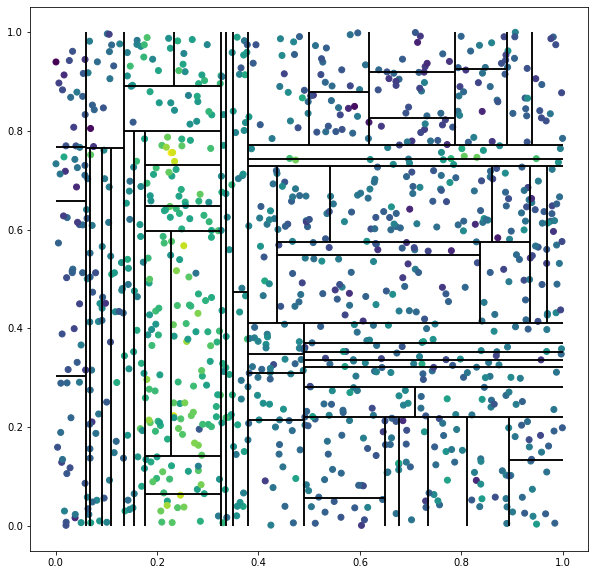

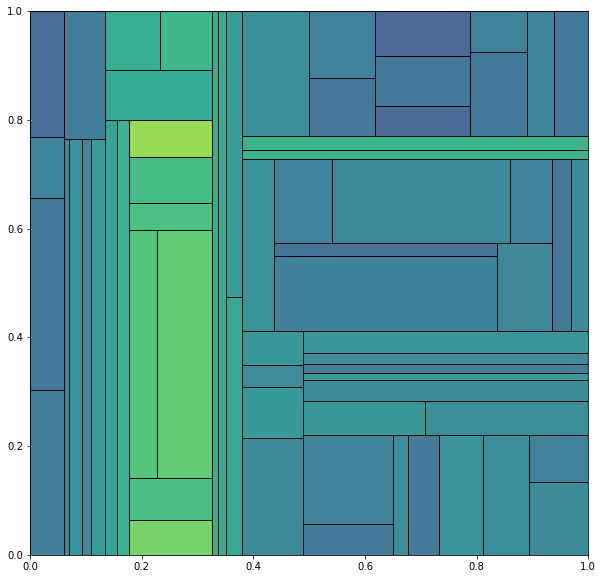

In [16]:
boxes(tree_reg,data1,labels)